# Notebook #01: ALE analyses

This first notebook computes coordinate-based meta-analyses using the activation likelihood estimation (ALE) algorithm (Eickhoff et al., 2009; 2012; Turkeltaub et al., 2002). It takes as its inputs a table with descriptive information about all included experiments (which is stored in a Pandas DataFrame), and the individual peak coordinates from these experiments (read from individual CSV-files and stored as 2D NumPy arrays within the DataFrame). It then writes these coordinates to a Sleuth text file (for an example, see [http://www.brainmap.org/ale/foci2.txt](http://www.brainmap.org/ale/foci2.txt)). This text file is fed into the ALE algorithm as implemented in the [NiMARE package](https://nimare.readthedocs.io). This is done once for all experiments included in the meta-analysis and for seperate subgroups of experiments (e.g. based on specific categories of semantic tasks or the mean age of the children).

We start by reading the table of experiments.

In [1]:
# Read table of included experiments
import pandas as pd
exps = pd.read_csv('../data/literature_search/included.csv', na_filter=False,
                   converters={'age_mean': float, 'age_min': float, 'age_max': float})

Next, we take care of the fact that two experiments don't report the mean age of the children in the article. To nevertheless be able to inlcude these experiments (when assessing the influence of age), we use the midpoint of the age range instead of the mean. We also compute the median accross the mean sample ages of all experiments, which we will use later on to perform a median split analysis (older vs. younger).

In [2]:
# Fill in mean age if missing (replace with the midpoint of min and max)
import numpy as np
exps['age_mean'] = [np.mean([age_min, age_max])
                    if np.isnan(age_mean) else age_mean
                    for age_mean, age_min, age_max
                    in zip(exps['age_mean'], exps['age_min'], exps['age_max'])]

# Compute median of mean ages (for median split)
age_md = exps['age_mean'].median()

We can then read the peak coordinates from the individual CSV files for all experiments. When necessary, we convert coordinates reported in Talairach space to (common) MNI space.

In [3]:
# Read peak coordinates from CSV files
exps['fname'] = '../data/foci/' + exps['experiment'] + '.csv'
exps['foci'] = [np.genfromtxt(fname, delimiter=",", skip_header=1)
                for fname in exps['fname']]

# Make sure all foci are stored as 2D NumPy arrays
exps['foci'] = [np.expand_dims(foci, axis=0)
                if np.ndim(foci) != 2 else foci
                for foci in exps['foci']]

# Convert from Talairach to MNI space if necessary
from nimare.transforms import tal2mni
exps['foci_mni'] = [tal2mni(foci[:,0:3])
                    if foci_space == 'TAL' else foci[:,0:3]
                    for foci, foci_space in zip(exps['foci'], exps['foci_space'])]

We then need to create the Sleuth text files on which can be read by GingerALE to perform the actual ALE meta-analyses. We therefore define a function which takes as its input the experiments DataFrame and a query for subsetting it (if we want to perform the analysis on a subset of all experiments). We can provide this information as a dictionary together with the desired file names for the text files.

In [4]:
# Define function to write a subset of the experiments to a Sleuth text file
def write_foci(fname, df, query):
    from os import makedirs, path
    makedirs(path.dirname(fname), exist_ok=True)
    f = open(file = fname, mode = 'w')
    f.write('// Reference=MNI\n')
    f.close()
    f = open(file = fname, mode = 'a')
    df_sub = df.query(query)
    for experiment, n, foci_mni in zip(df_sub['experiment'], df_sub['n'], df_sub['foci_mni']):
        f.write('// ' + experiment + '\n// Subjects=' + str(n) + '\n')
        np.savetxt(f, foci_mni, fmt='%1.3f', delimiter='\t')
        f.write('\n')
    f.close()


# Define dictionary for which ALE analyses to run
ales = dict({'../results/ale/all.txt': 'experiment == experiment',
             '../results/ale/knowledge.txt': 'task_type == "knowledge"',
             '../results/ale/nknowledge.txt': 'task_type != "knowledge"',
             '../results/ale/lexical.txt': 'task_type == "lexical"',
             '../results/ale/nlexical.txt': 'task_type != "lexical"',
             '../results/ale/objects.txt': 'task_type == "objects"',
             '../results/ale/nobjects.txt': 'task_type != "objects"',
             '../results/ale/older.txt': 'age_mean > @age_md',
             '../results/ale/younger.txt': 'age_mean <= @age_md'})

# Use the function to write the Sleuth files
for key, value in zip(ales.keys(), ales.values()):
    write_foci(fname=key, df=exps, query=value)


We are now ready to perform the actual ALE analyses with NiMARE. We write a custom function which takes a single Sleuth text file as its input and performs the actual estimation, Monte Carlo-based FWE correction (correcting for multiple comparisons on the cluster level). We then apply this function to all the Sleuth files we have created in the previous step.

In [5]:
# Define function for performing a single ALE analysis with FWE correction
def run_ale(text_file, voxel_thresh, cluster_thresh, n_iters, output_dir):
    print('PERFORMING ALE FOR "' + text_file + '" WITH ' + str(n_iters) + ' PERMUTATIONS')
    # Run ALE
    from nimare import io, meta, correct
    dset = io.convert_sleuth_to_dataset(text_file=text_file)
    ale = meta.cbma.ALE()
    res = ale.fit(dset)
    # Perform FWE correction
    corr = correct.FWECorrector(method="montecarlo", voxel_thresh=voxel_thresh, n_iters=n_iters)
    cres = corr.transform(result=res)
    # Save maps to ouput folder
    from os.path import basename
    prefix = basename(text_file).replace('.txt', '')
    res.save_maps(output_dir=output_dir, prefix=prefix)
    cres.save_maps(output_dir=output_dir, prefix=prefix)
    # Create cluster-level thresholded Z- and ALE-maps
    from scipy.stats import norm
    from nilearn.image import threshold_img, math_img
    from nibabel import save
    img_clust = cres.get_map('z_level-cluster_corr-FWE_method-montecarlo')
    img_z = cres.get_map('z')
    img_ale = cres.get_map('ale')
    cluster_thresh_z = norm.ppf(1 - cluster_thresh / 2)
    img_clust_thresh = threshold_img(img=img_clust, threshold=cluster_thresh_z)
    img_mask = math_img('np.where(img > 0, 1, 0)', img=img_clust_thresh)
    img_z_thresh = math_img('img1 * img2', img1=img_mask, img2=img_z)
    img_ale_thresh = math_img('img1 * img2', img1=img_mask, img2=img_ale)
    save(img=img_z_thresh, filename=output_dir + '/' + prefix + '_z_thresholded.nii.gz')
    save(img=img_ale_thresh, filename=output_dir + '/' + prefix + '_ale_thresholded.nii.gz')


# Apply the function to all our Sleuth files
for key in ales.keys():
    run_ale(text_file=key, voxel_thresh=0.001, cluster_thresh=0.01,
            n_iters=1000, output_dir="../results/ale")


PERFORMING ALE FOR "../results/ale/all.txt" WITH 100 PERMUTATIONS

PERFORMING ALE FOR "../results/ale/younger.txt" WITH 100 PERMUTATIONS



INFO:nimare.correct:Using correction method implemented in Estimator: <class 'nimare.meta.cbma.ale.ALE'>.correct_fwe_montecarlo.
/Users/alexander/opt/anaconda3/envs/mask_children/lib/python3.7/site-packages/nimare/meta/cbma/ale.py:360: RuntimeWarning: divide by zero encountered in log
  logp_cfwe_values = -np.log(p_cfwe_values)
/Users/alexander/opt/anaconda3/envs/mask_children/lib/python3.7/site-packages/nimare/meta/cbma/ale.py:372: RuntimeWarning: divide by zero encountered in log
  logp_vfwe_values = -np.log(p_vfwe_values)
INFO:nimare.correct:Using correction method implemented in Estimator: <class 'nimare.meta.cbma.ale.ALE'>.correct_fwe_montecarlo.


Finally, let's look at some exemplary results by plotting the (cluster-wise FWE-corrected) *Z*-score map from the main analysis (including all semantic experiments) and by printing the corresponding cluster table.

Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)
1,36,22,-6,7.55,2984
2,-4,16,50,7.51,6048
3,-52,-38,4,7.12,2664
4,-44,18,24,6.51,10856
5,40,-52,-18,4.98,1584
6,-40,-52,-20,4.91,3640
7,36,-90,-6,4.34,2128
8,46,-64,-10,3.80,336


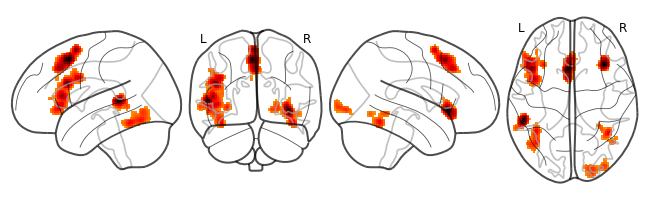

In [7]:
# Glass brain example
from nilearn import image, plotting, reporting
img_thresholded = image.load_img('../results/ale/all_z_thresholded.nii.gz')
p = plotting.plot_glass_brain(img_thresholded, display_mode='lyrz')

# Cluster table example
t = reporting.get_clusters_table(img_thresholded, stat_threshold=0, min_distance=1000)
t.style.format({'X': '{:.0f}', 'Y': '{:.0f}', 'Z': '{:.0f}', 'Peak Stat': '{:.2f}'}).hide_index()
